<a href="https://colab.research.google.com/github/yadnyeshkhotre/TWGAN/blob/main/TWGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


///content/drive/MyDrive/111/GT/
///content/drive/MyDrive/111/hazy/
(384, 384, 3)


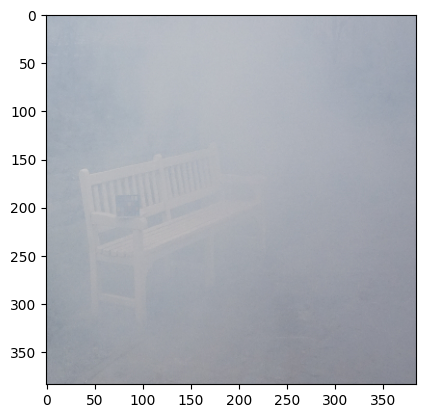

(384, 384, 3)


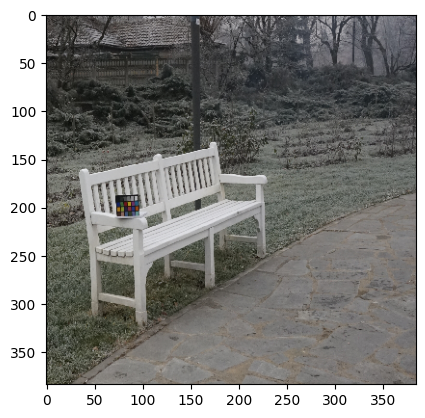

In [9]:
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import math
from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

clear_path = r'///content/drive/MyDrive/111/GT'
hazy_path = r'///content/drive/MyDrive/111/hazy'
a = 384

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, a, a, 3])
    return cropped_image[0], cropped_image[1]

def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 384, 384)
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def load_images(path):
    src_list = []
    x = os.path.join(path, '')
    print(x)
    for filename in sorted_alphanumeric(os.listdir(path)):
        if filename == ".ipynb_checkpoints":
            continue
        if filename == "Dehaze_GAN-SOTS.h5":
          continue
        else:
            pixels = load_img(os.path.join(x, filename), target_size=(a, a))
            pixels = tf.keras.preprocessing.image.img_to_array(pixels)
            pixels = (pixels - 127.5) / 127.5  # Normalize to [-1, 1]
            src_list.append(pixels)
    return src_list
     #Haze Removal Function
def dehaze_image(img_name):
    input_image_orig = np.asarray(Image.open(img_name))/255.0
    input_image = np.pad(input_image_orig,((8,9), (8,9), (1,1)),'symmetric')

    model = TransmissionModel(input_image.shape)
    model.load_weights('transmodel_weights.h5')

    input_image = np.expand_dims(input_image, axis=0)
    trans_map_orig = model.predict(input_image)
    trans_map = trans_map_orig.reshape(input_image_orig.shape[:2])
    trans_map_refine = TransmissionRefine((input_image_orig*255.0).astype('uint8'),trans_map)

    res_map_input = input_image_orig/np.expand_dims(trans_map_refine, axis=(0,4))

    model = ResidualModel(res_map_input.shape[2:])
    model.load_weights('resmodel_weights.h5')
    res_map_output = model.predict(np.clip(res_map_input,0,2))

    haze_free_image = (res_map_input-res_map_output)
    haze_free_image = np.clip(haze_free_image,0,2)

    return haze_free_image[0]

# Load and process images:
clear = load_images(clear_path)
hazy = load_images(hazy_path)

# Resize the images to 256x256 and apply random jitter
hazy, clear = zip(*[random_jitter(h, c) for h, c in zip(hazy, clear)])

# Convert to numpy arrays
hazy = np.array(hazy, dtype='float32')
clear = np.array(clear, dtype='float32')

# Keep only the first 400 images
hazy = hazy[:400]
clear = clear[:400]

plt.imshow(0.5 * hazy[20] + 0.5)
print((0.5 * hazy[0] + 0.5).shape)
plt.show()
plt.imshow((0.5 * clear[20] + 0.5))
print((0.5 * clear[0] + 0.5).shape)
plt.show()


In [ ]:
# to save the images in colab
plt.imsave("V3.png",(0.5 * clear[20] + 0.5))

plt.imsave("V2.png",0.5 * hazy[20] + 0.5)


In [ ]:
print(hazy.shape)

(55, 256, 256, 3)


In [10]:
import keras
import tensorflow as tf
from keras.optimizers import Adam, Lion
from keras.losses import mae
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization
from matplotlib import pyplot as plt
from os import listdir
import cv2
import numpy as np
import os
import tensorflow.keras.applications.vgg19 as vgg19
from tensorflow.keras.losses import mean_absolute_error
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error



def psnr(original, compressed):
    # Calculate the mean squared error (MSE) using TensorFlow
    mse = tf.reduce_mean(tf.square(original - compressed))

    # Calculate the peak signal-to-noise ratio (PSNR)
    max_pixel = 1.0
    psnr = 20 * tf.math.log(max_pixel / tf.sqrt(mse)) / tf.math.log(10.0)

    return psnr


def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4, 4), strides=(1, 1), padding='valid', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(1, (4, 4), strides=(1, 1), padding='valid', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    model = Model([in_src_image, in_target_image], patch_out, name='discriminator')
    # compile model
    return model


def define_encoder_block(layer_in, n_filters, batchnorm=False):
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization(momentum=0.8)(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)

    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


class TransformerGenerator(Model):
    def __init__(self, image_shape):
        super(TransformerGenerator, self).__init__()

        init = RandomNormal(stddev=0.02)
        in_image = Input(shape=image_shape)
        e1 = define_encoder_block(in_image, 64, batchnorm=True)
        e2 = define_encoder_block(e1, 128, batchnorm=True)
        e3 = define_encoder_block(e2, 256, batchnorm=True)
        e4 = define_encoder_block(e3, 512, batchnorm=True)
        e5 = define_encoder_block(e4, 512, batchnorm=True)
        e6 = define_encoder_block(e5, 512, batchnorm=True)
        b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e6)
        b = Activation('relu')(b)
        d2 = decoder_block(b, e6, 512, dropout=True)
        d3 = decoder_block(d2, e5, 512, dropout=True)
        d4 = decoder_block(d3, e4, 256, dropout=True)
        d5 = decoder_block(d4, e3, 128, dropout=True)
        d6 = decoder_block(d5, e2, 64, dropout=True)
        d7 = decoder_block(d6, e1, 64, dropout=True)
        g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
        out_image = Activation('tanh')(g)
        self.generator = Model(in_image, out_image, name='generator')

    def call(self, inputs):
        return self.generator(inputs)


def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4, 4), strides=(1, 1), padding='valid', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(1, (4, 4), strides=(1, 1), padding='valid', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    model = Model([in_src_image, in_target_image], patch_out, name='discriminator')
    # compile model
    return model


def define_encoder_block(layer_in, n_filters, batchnorm=False):
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization(momentum=0.8)(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)

    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


def discriminator_loss(real_logit, fake_logit):
    real_loss = tf.reduce_mean(tf.keras.losses.hinge(tf.ones_like(real_logit), real_logit))
    fake_loss = tf.reduce_mean(tf.keras.losses.hinge(tf.zeros_like(fake_logit), fake_logit))
    return real_loss + fake_loss


def generator_loss(fake_logit):
    return -tf.reduce_mean(fake_logit)


class WGAN(Model):
    def __init__(self, discriminator, generator, discriminator_extra_steps, gp_weight=10.0):
        super(WGAN, self).__init__()

        self.discriminator = discriminator
        self.generator = generator
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

        # Create the VGG model for feature extraction
        self.vgg = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(384, 384, 3))
        self.vgg.trainable = False
        self.feature_extractor = tf.keras.Model(inputs=self.vgg.input, outputs=self.vgg.get_layer('block4_conv2').output)

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, target_images):
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator([real_images, interpolated], training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, target_images = data
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        if isinstance(target_images, tuple):
            target_images = target_images[0]

        batch_size = tf.shape(real_images)[0]
        d_loss_f = 0
        for i in range(self.d_steps):
            # Get the latent vector
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(real_images, training=True)
                l1 = mean_absolute_error(real_images, fake_images)

                fake_logits = self.discriminator([real_images, fake_images], training=True)
                real_logits = self.discriminator([real_images, target_images], training=True)

                d_loss = self.d_loss_fn(real_logits, fake_logits)
                d_loss_f = d_loss_f + d_loss

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        d_loss_f = tf.reduce_mean(d_loss_f)

        with tf.GradientTape() as tape, tf.GradientTape() as gtape:
            generated_images = self.generator(real_images, training=True)
            l1 = tf.reduce_mean(mean_absolute_error(target_images, generated_images))
            gen_img_logits = self.discriminator([real_images, generated_images], training=True)

            target_features = self.feature_extractor(0.5 * target_images + 0.5)
            generated_features = self.feature_extractor(0.5 * generated_images + 0.5)
            vgg_loss = tf.reduce_mean(tf.square(target_features - generated_features))

            g_loss = self.g_loss_fn(gen_img_logits) + 100 * l1 + 0.0001 * vgg_loss

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"d_loss": d_loss_f, "g_loss": g_loss}


a = 384
image_shape = (a, a, 3)
vgg = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(384, 384, 3))
layer_name = 'block4_conv2'
vgg_outputs = vgg.get_layer(layer_name).output
feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=vgg_outputs)
feature_extractor.trainable = False
d_model = define_discriminator(image_shape)
g_model = TransformerGenerator(image_shape)


generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)


epochs = 50

wgan = WGAN(discriminator=d_model, generator=g_model, discriminator_extra_steps=1)
wgan.compile(d_optimizer=discriminator_optimizer,
             g_optimizer=generator_optimizer, g_loss_fn=generator_loss, d_loss_fn=discriminator_loss)



/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [11]:
# Training
print("Training has been started")
wgan.fit(hazy, clear, batch_size=8, epochs=epochs)

import os
os.makedirs("/content/drive/MyDrive/NH_HAZE/modelWeightFile", exist_ok=True)

# Save the generator model using SavedModel format
generator_save_path = "/content/drive/MyDrive/NH_HAZE/modelWeightFile/Dehaze_GAN-SOTS"
tf.saved_model.save(wgan.generator, generator_save_path)


Training has been started
Epoch 1/50
7/7 [==============================] - 41s 3s/step - d_loss: 1.8754 - g_loss: 39.9565
Epoch 2/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.6799 - g_loss: 36.2239
Epoch 3/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.6481 - g_loss: 35.3127
Epoch 4/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.6877 - g_loss: 34.2878
Epoch 5/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.6259 - g_loss: 34.6596
Epoch 6/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.6441 - g_loss: 32.8097
Epoch 7/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.6299 - g_loss: 33.3362
Epoch 8/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.6418 - g_loss: 32.5997
Epoch 9/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.6027 - g_loss: 33.3962
Epoch 10/50
7/7 [==============================] - 8s 1s/step - d_loss: 1.5129 - g_loss: 33.2431
Epoch 11/50


In [ ]:
import cv2;
import math;
import numpy as np;
import pandas as pd;

In [ ]:
def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import cv2 #image processing
import numpy as np #matrix operations
from google.colab.patches import cv2_imshow #display in colab
if __name__ == '__main__':
    import sys

    fn = '/content/drive/MyDrive/archive/hazy/01_hazy.png'


    src = cv2.imread(fn);

    I = src.astype('float64')/255;

    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);

    cv2_imshow(dark*255);
    cv2_imshow(t*255);
    cv2_imshow(src);
    A1_dehazed=cv2_imshow(J*255)
    A1_dehazed=J*255

In [ ]:
generated_dehaze_image=B1_dehazed

In [ ]:
if __name__ == '__main__':
    import sys

    fn = '/content/drive/MyDrive/archive/hazy/01_hazy.png'


    src = cv2.imread(fn);

    I = src.astype('float64')/255;

    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);

    cv2_imshow(dark*255);
    cv2_imshow(t*255);
    cv2_imshow(src);
    cv2_imshow(J*255)
    B1_dehazed=J*255
    #cv2_imshow(J);
    #cv2.imwrite("input.jpg",J*255);
    #cv2.waitKey();

In [ ]:
cv2_imshow(A1_dehazed)
cv2_imshow(B1_dehazed)
cv2.imwrite('/content/drive/MyDrive/archive/hazy/01_hazy.png',A1_dehazed)
cv2.imwrite('/content/drive/MyDrive/archive/hazy/01_hazy.png',B1_dehazed)

In [ ]:
import h5py

# Save A1_dehazed as .h5 file
with h5py.File('/content/drive/MyDrive/A1_dehazed.h5', 'w') as hf:
    hf.create_dataset('data', data=A1_dehazed)

# Save B1_dehazed as .h5 file
with h5py.File('/content/drive/MyDrive/B1_dehazed.h5', 'w') as hf:
    hf.create_dataset('data', data=B1_dehazed)

In [ ]:
import os

# Get the file size in bytes
file_size = os.path.getsize('/content/drive/MyDrive/A1_dehazed.h5')


# Convert bytes to a human-readable format
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_names = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    size = round(size_bytes / math.pow(1024, i), 2)
    return f"{size} {size_names[i]}"

# Convert the file size to a human-readable format
file_size_hr = convert_size(file_size)

# Print the file size
print(f"The file size is: {file_size_hr}")

In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Assuming you have generated the dehaze image and stored it in the variable 'generated_dehaze_image'

# Load the hazy image
hazy_image = cv2.imread("/content/drive/MyDrive/training/hazy/13_hazy.png")

# Convert the images to grayscale
hazy_image_gray = cv2.cvtColor(hazy_image, cv2.COLOR_BGR2GRAY)

# Convert the generated dehaze image to a supported depth type (e.g., 8-bit unsigned)
generated_dehaze_image = generated_dehaze_image.astype(np.uint8)

# Convert the dehaze image to grayscale
dehazed_image_gray = cv2.cvtColor(generated_dehaze_image, cv2.COLOR_BGR2GRAY)

# Calculate MSE
mse = np.mean((hazy_image_gray - dehazed_image_gray) ** 2)

# Calculate PSNR
psnr = cv2.PSNR(hazy_image_gray, dehazed_image_gray)

# Calculate SSIM
ssim_score = ssim(hazy_image_gray, dehazed_image_gray)

print("MSE:", mse)
print("PSNR:", psnr)
print("SSIM:", ssim_score)


In [ ]:
import os
import shutil
os.makedirs("/content/drive/MyDrive/NH-HAZE/GT",exist_ok=True)
os.makedirs("/content/drive/MyDrive/NH-HAZE/hazy",exist_ok=True)

for i in os.listdir("/content/drive/MyDrive/NH-HAZE/NH-HAZE"):
  if "GT" in i:
    shutil.move(f"/content/drive/MyDrive/NH-HAZE/NH-HAZE/{i}",f"/content/drive/MyDrive/NH-HAZE/GT/{i}")
  print(i)

02_hazy.png
02_GT.png
01_hazy.png
01_GT.png
05_GT.png
04_hazy.png
04_GT.png
03_hazy.png
03_GT.png
07_GT.png
06_hazy.png
06_GT.png
05_hazy.png
10_GT.png
09_hazy.png
09_GT.png
08_hazy.png
08_GT.png
07_hazy.png
12_hazy.png
12_GT.png
11_hazy.png
11_GT.png
10_hazy.png
15_GT.png
14_hazy.png
14_GT.png
13_hazy.png
13_GT.png
17_GT.png
16_hazy.png
16_GT.png
15_hazy.png
21_hazy.png
21_GT.png
20_hazy.png
20_GT.png
19_hazy.png
19_GT.png
18_hazy.png
18_GT.png
17_hazy.png
24_hazy.png
24_GT.png
23_hazy.png
23_GT.png
22_hazy.png
22_GT.png
26_hazy.png
26_GT.png
25_hazy.png
25_GT.png
32_GT.png
31_hazy.png
31_GT.png
30_hazy.png
30_GT.png
29_hazy.png
29_GT.png
28_hazy.png
28_GT.png
27_hazy.png
27_GT.png
37_GT.png
36_hazy.png
36_GT.png
35_hazy.png
35_GT.png
34_hazy.png
34_GT.png
33_hazy.png
33_GT.png
32_hazy.png
42_hazy.png
42_GT.png
41_hazy.png
41_GT.png
40_hazy.png
40_GT.png
39_hazy.png
39_GT.png
38_hazy.png
38_GT.png
37_hazy.png
47_hazy.png
47_GT.png
46_hazy.png
46_GT.png
45_hazy.png
45_GT.png
44_hazy.pn